# Problem 3, Latin Alphabet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%matplotlib inline

## A) 

In [2]:
df_train = pd.read_csv("./data/HW2_data/Q3_train.csv")
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


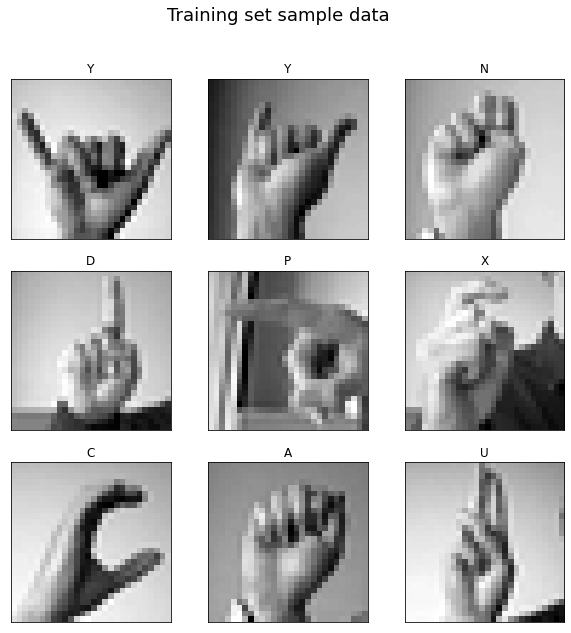

In [3]:
train_samples = df_train.sample(9).to_numpy()
fig, ax = plt.subplots(3, 3, figsize=(10,10))
fig.suptitle("Training set sample data", fontsize=18)
for i in range(9):
    ax[i//3,i%3].set_xticks([])
    ax[i//3,i%3].set_yticks([])
    ax[i//3,i%3].imshow(train_samples[i, 1:].reshape(28, 28), cmap='gray')
    ax[i//3,i%3].set_title(f"{chr(train_samples[i, 0]+65)}")
plt.show()

## B)

In [4]:
df_test = pd.read_csv("./data/HW2_data/Q3_test.csv")
df_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


## Splitting data

In [5]:
raw_training_set = df_train.to_numpy()
test_set = df_test.to_numpy()
# extract validation from training set
training_set = raw_training_set[0:int(0.8*raw_training_set.shape[0])]
validation_set = raw_training_set[int(0.8*raw_training_set.shape[0]):]
print(f"training set: {training_set.shape}\nvalidation set:{validation_set.shape}\ntest set:{test_set.shape}")

training set: (21964, 785)
validation set:(5491, 785)
test set:(7172, 785)


## Defining custom dataset

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class LatinAlphDataset(Dataset):
    def __init__(self, raw_set):
        self.X = raw_set[:, 1:]
        self.y = raw_set[:, 0]
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        features = torch.from_numpy(self.X[idx]).float().to(device)
        label = torch.tensor(self.y[idx], dtype=float, device=device)
        return features, label

Using cuda device


In [7]:
train_dataset = LatinAlphDataset(training_set)
validation_dataset = LatinAlphDataset(validation_set)
test_dataset = LatinAlphDataset(test_set)

## Model architecture

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 25)
        )
    def forward(self, X):
        return self.lin_stack(X)

## Training model

In [10]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    def train(self, train_dl):
        self.model.train()
        for batch_idx, (Xt, yt) in enumerate(train_dl):
            logits = self.model(Xt.float())
            yt = yt.type(torch.LongTensor).to(device)
            loss = self.loss_fn(logits, yt)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if batch_idx % 100 == 0:
                loss, current = loss.item(), batch_idx * len(Xt)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dl.dataset):>5d}]")
    def calAccAndLossOnSet(self, dl):
        self.model.eval()
        loss, correct = 0, 0
        with torch.no_grad():
            for (X, y) in dl:
                logits = self.model(X)
                loss += self.loss_fn(logits, y.type(torch.LongTensor).to(device))
                preds = nn.Softmax(dim=1)(logits)
                correct += ( preds.argmax(dim=1) == y ).sum().item()
        loss /= len(dl)
        correct /= len(dl.dataset)
        return loss, correct

### 1) SGD algorithm 

In [12]:
learning_rate = 1e-4
batch_size = 64
epochs = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model_sgd = Model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate)

print("Training the model with SGD algorithm")
trainer1 = Trainer(model_sgd, loss_fn, optimizer)
train_losses = []
train_accs = []
validation_losses = []
validation_accs = []
for epoch in range(epochs):
    print(f"At epoch {epoch+1}")
    print("===========================")
    trainer1.train(train_dataloader)
    loss, acc = trainer1.calAccAndLossOnSet(train_dataloader)
    train_losses.append(loss.item())
    train_accs.append(acc*100)
    print(f"Train Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f}")
    loss, acc = trainer1.calAccAndLossOnSet(validation_dataloader)
    validation_losses.append(loss.item())
    validation_accs.append(acc*100)
    print(f"Validation Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

Training the model with SGD algorithm
At epoch 1
loss: 32.475613  [    0/21964]
loss: 2.876460  [ 6400/21964]
loss: 2.362006  [12800/21964]
loss: 1.784667  [19200/21964]
Train Error: 
 Accuracy: 47.8%, Avg loss: 1.747752
Validation Error: 
 Accuracy: 48.3%, Avg loss: 1.734653 

At epoch 2
loss: 1.777679  [    0/21964]
loss: 1.283099  [ 6400/21964]
loss: 1.751493  [12800/21964]
loss: 1.325406  [19200/21964]
Train Error: 
 Accuracy: 52.4%, Avg loss: 1.592256
Validation Error: 
 Accuracy: 52.4%, Avg loss: 1.591645 

At epoch 3
loss: 1.443602  [    0/21964]
loss: 1.278250  [ 6400/21964]
loss: 0.902356  [12800/21964]
loss: 1.101231  [19200/21964]
Train Error: 
 Accuracy: 61.6%, Avg loss: 1.161166
Validation Error: 
 Accuracy: 62.6%, Avg loss: 1.147194 

At epoch 4
loss: 1.205894  [    0/21964]
loss: 0.853423  [ 6400/21964]
loss: 0.737583  [12800/21964]
loss: 0.528580  [19200/21964]
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.922401
Validation Error: 
 Accuracy: 69.8%, Avg loss: 0.903522 

A

Test Error: 
 Accuracy: 72.3%, Avg loss: 1.065793 



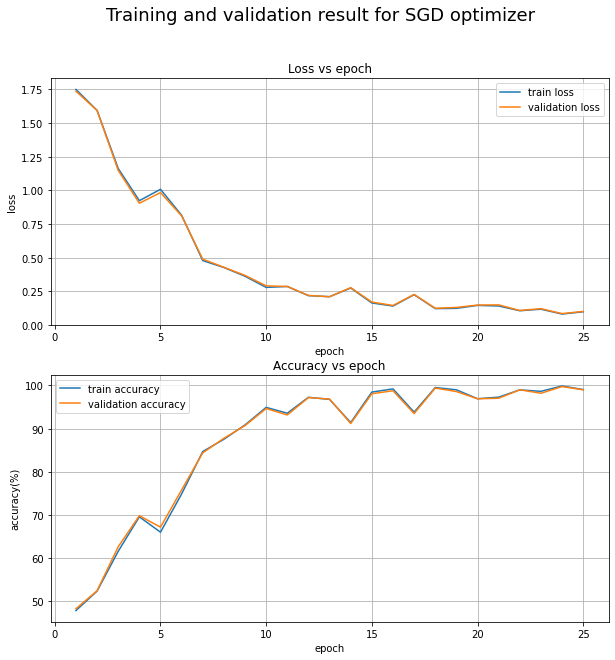

In [13]:
# save model:
torch.save(model_sgd, "models/p3-sgd.pt")

# test error:
loss, acc = trainer1.calAccAndLossOnSet(test_dataloader)
print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

fig, ax = plt.subplots(2, figsize=(10,10))
fig.suptitle("Training and validation result for SGD optimizer", fontsize=18)
ax[0].plot(range(1, epochs+1), train_losses)
ax[0].plot(range(1, epochs+1), validation_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_title("Loss vs epoch")
ax[0].legend(["train loss", "validation loss"])
ax[0].grid(True)
ax[1].plot(range(1, epochs+1), train_accs)
ax[1].plot(range(1, epochs+1), validation_accs)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy(%)")
ax[1].set_title("Accuracy vs epoch")
ax[1].legend(["train accuracy", "validation accuracy"])
ax[1].grid(True)
plt.show()

### 2) Adam algorithm

In [14]:
learning_rate = 1e-4
batch_size = 64
epochs = 25

model_adam = Model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_adam.parameters(), lr=learning_rate)

print("Training the model with Adam algorithm")
trainer2 = Trainer(model_adam, loss_fn, optimizer)
train_losses = []
train_accs = []
validation_losses = []
validation_accs = []
for epoch in range(epochs):
    print(f"At epoch {epoch+1}")
    print("===========================")
    trainer2.train(train_dataloader)
    loss, acc = trainer2.calAccAndLossOnSet(train_dataloader)
    train_losses.append(loss.item())
    train_accs.append(acc*100)
    print(f"Train Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f}")
    loss, acc = trainer2.calAccAndLossOnSet(validation_dataloader)
    validation_losses.append(loss.item())
    validation_accs.append(acc*100)
    print(f"Validation Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

Training the model with Adam algorithm
At epoch 1
loss: 38.627636  [    0/21964]
loss: 2.548685  [ 6400/21964]
loss: 1.008155  [12800/21964]
loss: 1.181907  [19200/21964]
Train Error: 
 Accuracy: 62.6%, Avg loss: 1.182507
Validation Error: 
 Accuracy: 63.4%, Avg loss: 1.149340 

At epoch 2
loss: 1.327275  [    0/21964]
loss: 0.728820  [ 6400/21964]
loss: 0.539357  [12800/21964]
loss: 0.319918  [19200/21964]
Train Error: 
 Accuracy: 84.8%, Avg loss: 0.463586
Validation Error: 
 Accuracy: 84.5%, Avg loss: 0.465065 

At epoch 3
loss: 0.495348  [    0/21964]
loss: 0.231100  [ 6400/21964]
loss: 0.241895  [12800/21964]
loss: 0.091756  [19200/21964]
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.127941
Validation Error: 
 Accuracy: 97.5%, Avg loss: 0.130511 

At epoch 4
loss: 0.160636  [    0/21964]
loss: 0.224637  [ 6400/21964]
loss: 0.106084  [12800/21964]
loss: 0.090178  [19200/21964]
Train Error: 
 Accuracy: 97.7%, Avg loss: 0.095173
Validation Error: 
 Accuracy: 97.1%, Avg loss: 0.104437 



Test Error: 
 Accuracy: 78.7%, Avg loss: 0.915772 



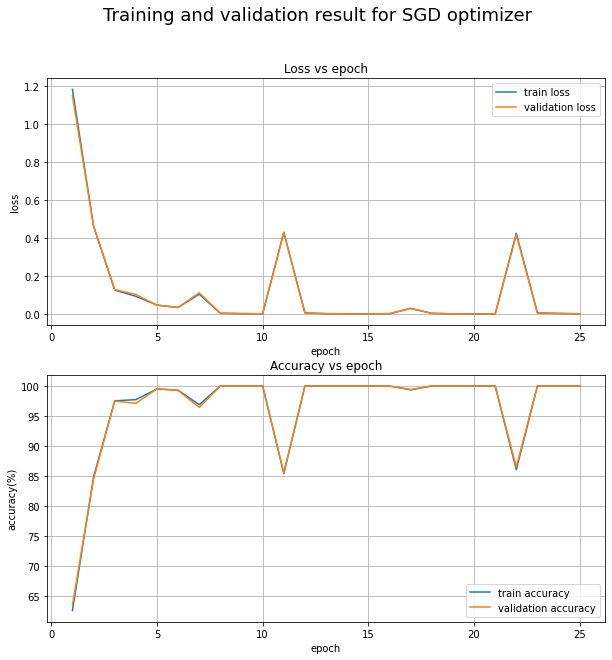

In [15]:
# save model:
torch.save(model_adam, "models/p3-adam.pt")
# test error:
loss, acc = trainer2.calAccAndLossOnSet(test_dataloader)
print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

fig, ax = plt.subplots(2, figsize=(10,10))
fig.suptitle("Training and validation result for SGD optimizer", fontsize=18)
ax[0].plot(range(1, epochs+1), train_losses)
ax[0].plot(range(1, epochs+1), validation_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_title("Loss vs epoch")
ax[0].legend(["train loss", "validation loss"])
ax[0].grid(True)
ax[1].plot(range(1, epochs+1), train_accs)
ax[1].plot(range(1, epochs+1), validation_accs)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy(%)")
ax[1].set_title("Accuracy vs epoch")
ax[1].legend(["train accuracy", "validation accuracy"])
ax[1].grid(True)
plt.show()

### Explanation:

Adam is a better optimzier compared with traditional SGD. Adam combines AdaGrad and RMSProvb algorithms and provides better results in terms of optimization. Adam maintains per-parameter learning rate that leads to significant performance enhancments than SGD which uses a single learning rate parameter. 

As you can see, Adam achieves better accuracy on test set compared to SGD on the same model with similar hyperparameters. 

|Algorithm|Validation acc|Validation loss|Test acc|Test loss|
|:----:|:----:|:----:|:----:|:----:|
|SGD|99.0%|0.100857|72.3%|1.065793| 
|Adam|100%|0.003397|78.7%|0.915772|

I used same hyperparameters for Adam and SGD optimizer so that the comparison would be valid. 

Validation set is derived from training set by splitting data. Thus, they are highly correlated and loss and accuracy values for train and validation sets are very close. Note that algorithms only is trained on training data not validation. 

Note that this table is filled with the results of the latest run of model (which are saved to the `models` directory). So, there might be changes in values when you run them due to randomness in optimization algorithm, batching process, etc.

## C)

In [18]:
droput_prob = 0.5
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.lin_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 25)
        )
    def forward(self, X):
        return self.lin_stack(X)

In [19]:
learning_rate = 1e-5
batch_size = 64
epochs = 150

model_dropout = DropoutModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=learning_rate)

print("Training the model+droput with Adam algorithm")
trainer3 = Trainer(model_dropout, loss_fn, optimizer)
train_losses = []
train_accs = []
validation_losses = []
validation_accs = []
for epoch in range(epochs):
    print(f"At epoch {epoch+1}")
    print("===========================")
    trainer3.train(train_dataloader)
    loss, acc = trainer3.calAccAndLossOnSet(train_dataloader)
    train_losses.append(loss.item())
    train_accs.append(acc*100)
    print(f"Train Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f}")
    loss, acc = trainer3.calAccAndLossOnSet(validation_dataloader)
    validation_losses.append(loss.item())
    validation_accs.append(acc*100)
    print(f"Validation Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

Training the model+droput with Adam algorithm
At epoch 1
loss: 67.220718  [    0/21964]
loss: 27.745239  [ 6400/21964]
loss: 11.125281  [12800/21964]
loss: 4.940572  [19200/21964]
Train Error: 
 Accuracy: 15.4%, Avg loss: 3.000001
Validation Error: 
 Accuracy: 15.4%, Avg loss: 2.992400 

At epoch 2
loss: 4.653078  [    0/21964]
loss: 3.774449  [ 6400/21964]
loss: 3.508770  [12800/21964]
loss: 3.221423  [19200/21964]
Train Error: 
 Accuracy: 18.0%, Avg loss: 2.963953
Validation Error: 
 Accuracy: 17.8%, Avg loss: 2.962821 

At epoch 3
loss: 3.294254  [    0/21964]
loss: 3.338010  [ 6400/21964]
loss: 3.248062  [12800/21964]
loss: 3.362803  [19200/21964]
Train Error: 
 Accuracy: 21.7%, Avg loss: 2.886529
Validation Error: 
 Accuracy: 21.9%, Avg loss: 2.881030 

At epoch 4
loss: 3.258190  [    0/21964]
loss: 3.220630  [ 6400/21964]
loss: 2.928354  [12800/21964]
loss: 2.870754  [19200/21964]
Train Error: 
 Accuracy: 27.9%, Avg loss: 2.775913
Validation Error: 
 Accuracy: 27.8%, Avg loss: 2.

Test Error: 
 Accuracy: 80.4%, Avg loss: 0.815004 



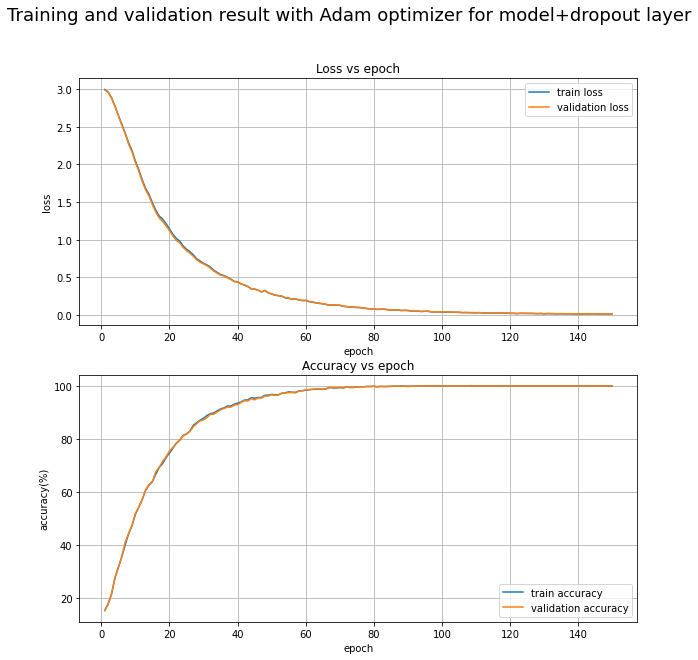

In [20]:
# save model:
model_dropout.eval()
torch.save(model_dropout, "models/p3-dropout.pt")
# test error:
loss, acc = trainer3.calAccAndLossOnSet(test_dataloader)
print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

fig, ax = plt.subplots(2, figsize=(10,10))
fig.suptitle("Training and validation result with Adam optimizer for model+dropout layer", fontsize=18)
ax[0].plot(range(1, epochs+1), train_losses)
ax[0].plot(range(1, epochs+1), validation_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_title("Loss vs epoch")
ax[0].legend(["train loss", "validation loss"])
ax[0].grid(True)
ax[1].plot(range(1, epochs+1), train_accs)
ax[1].plot(range(1, epochs+1), validation_accs)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy(%)")
ax[1].set_title("Accuracy vs epoch")
ax[1].legend(["train accuracy", "validation accuracy"])
ax[1].grid(True)
plt.show()

Dropout is a regularization technique and helps reducing the loss gap between test and train set. As you can see from previous parts, both models that are trained with SGD and Adam optimzer are in overfitting area. To increase performance on the test set, one solution is to use regularization techniques. There are various regularization methods and Dropout is one of them. As you can see, accuracy of Droput model is better than models without it. 

To train a model with droput layer, it takes more steps to train it compared with non-dropout case. So, instead of 25 epochs, I trained the network for 150 epochs. Although the validation and test accuracy is about 100% after 80 epochs, but I found out that the performance on test set is not acceptable. So, I trained the model for 150 epochs. 

I also tested both SGD and Adam algorithm. In my experiment, SGD didn't perform well and the final accuracy would be about 50% which is awful. But, Adam optimizer performs way better than SGD. I tested different learning rate and found out that the learning rate must be smaller than previous case. So, I choosed `lr=1e-5` and used default values for other parameters. 

## D) 
The following table summarizes accuracy of models on test set:

|Algorithm|Test acc|Test loss|
|:----:|:----:|:----:|
|Model+SGD|72.3%|1.065793| 
|Model+Adam|78.7%|0.915772|
|Model+Dropout+Adam|80.4%|0.815004|

As you can see the best performance is for the model with Dropout layer that is trained with Adam optimizer.

+ Note that these are the results of the latest run of this notebook. So, it's possible when you run it again, they change a little.

## E) 
I use `OpenCV` for getting images and feeding them to the network. I also assume that you have a webcam. If you don't have a webcam, you can run the following code to load an image:

```python
frame = cv2.imread("img.jpg", cv2.IMREAD_COLOR)
```

In [43]:
import cv2

### Online scenario

In [45]:
def preproc(img):
    img = cv2.resize(img, (28, 28))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return torch.from_numpy(img.reshape(1, -1)).float()

def postproc(logits):
    preds = nn.Softmax(dim=1)(logits)
    label = preds.argmax(dim=1)
    return chr(label+65)
    
# run inference on CPU
model_dropout.eval()
model_dropout.to('cpu')
cam = cv2.VideoCapture(0)
while True:
    _, frame = cam.read()
    # model pipeline
    det_char = postproc(model_dropout(preproc(frame)))
    frame = cv2.putText(frame, f"Detected char: {det_char}", (30, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),
                        2, cv2.LINE_AA)
    cv2.imshow('Model run', frame)
    key = cv2.waitKey(1)
    # enter 'q' to release the webcam
    if key == ord('q'):
        break
cam.release()
cv2.destroyAllWindows()

Sample outputs of running algorithm:

|C|Y|
|:------:|:---------:|
|![C char](./results/char-c.png)|![Y char](./results/char-y.png)|
|P|O|
|![P char](./results/char-p.png)|![O char](./results/char-o.png)|